# Calibrating a 3D age-rotation relation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
from george.kernels import ExpSquaredKernel, WhiteKernel
import pandas as pd
import emcee
from MCMC_plots import make_plot
import time
import h5py
import os
from teff_bv import teff2bv

RESULTS_DIR = "results"
DATA_DIR = "data"

Load all data: clusters + astero

In [2]:
def load_data():
    
    # load clusters
    bv1, bv_err1, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt(os.path.join(DATA_DIR, "clusters.txt")).T
    
    # load astero
    data = pd.read_csv(os.path.join(DATA_DIR, "vansaders.txt"))
    bv2 = teff2bv(data["Teff"], data["AMP_logg"], data["FeH"])
    bv_err2 = np.ones_like(bv2)*.1
    
    age = np.concatenate((a, np.array(data["AMP_age"])))
    age_err = np.concatenate((a_err, np.array(data["AMP_age_err"])))
    period = np.concatenate((p, np.array(data["period"])))
    period_err = period * .1
    bv = np.concatenate((bv1, bv2))
    bv_err = np.concatenate((bv_err1, bv_err2))
    logg = np.concatenate((np.ones_like(bv1)*4.4, data["AMP_logg"]))
    feh = np.concatenate((np.ones_like(bv1)*0., data["FeH"]))
    
    # remove very red stars
    m = bv < 1.2
    return age, age_err, bv, bv_err, period, period_err, logg, feh
    #return age[m], age_err[m], bv[m], bv_err[m], period[m], period_err[m], logg[m], feh[m]

In [3]:
age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()

Make 3D plot.

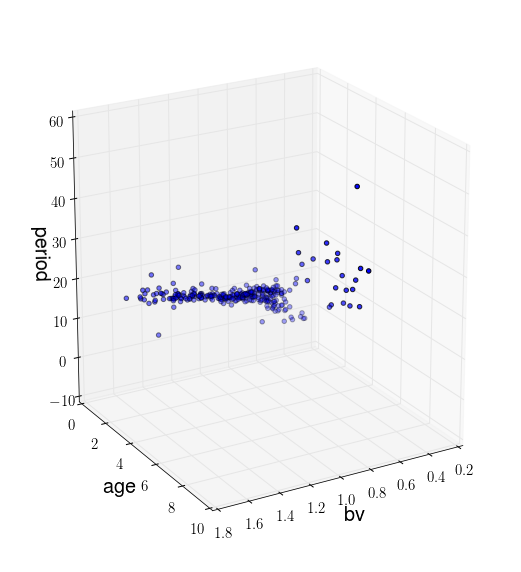

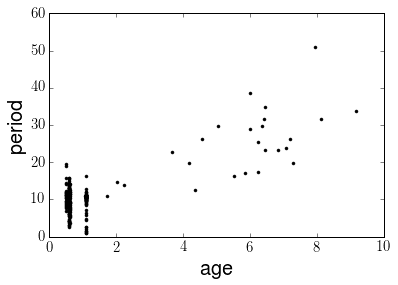

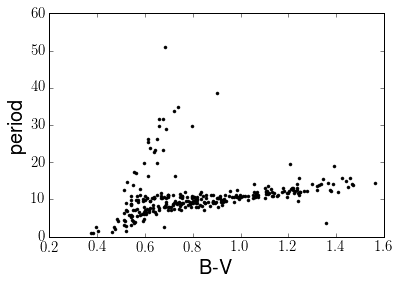

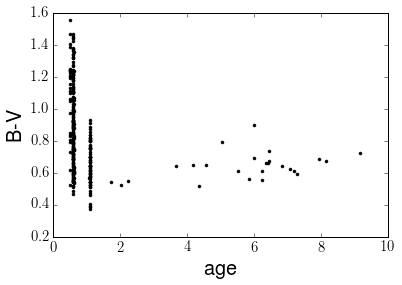

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(bv, age, period)
ax.set_xlabel("bv")
ax.set_ylabel("age")
ax.set_zlabel("period")
ax.view_init(20, 60)
plt.show()

plt.plot(age, period, "k.")
plt.xlabel("age")
plt.ylabel("period")
plt.show()

plt.plot(bv, period, "k.")
plt.xlabel("B-V")
plt.ylabel("period")
plt.show()

plt.plot(age, bv, "k.")
plt.xlabel("age")
plt.ylabel("B-V")
plt.show()

In [5]:
# set your x, y z and hyperparameters
D = np.vstack((bv, period)).T
A, lbv, lp = 10, 2000, 50

# GP prediction
k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
gp = george.GP(k)
gp.compute(D, age_err)

xs = np.zeros((1, 2))
xs[0, 0] = .65
xs[0, 1] = 26

mu, cov = gp.predict(age, xs)  # do the prediction
v = np.diag(cov)**.5
print(mu, "+/-", v)

[ 4.52827807] +/- [ 0.00110161]


Plot prediction for age vs period.

In [6]:
def plot_2d_prediction(x, y, xerr, yerr, mu, v, xs, theta, xlabel, ylabel):
    
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="k.")
    plt.errorbar(xs, mu, yerr=v, fmt="r.", ms=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    xplot = np.linspace(min(x), max(x), 100)
    k = theta[0]**2 * ExpSquaredKernel(theta[1]**2)
    gp = george.GP(k)
    gp.compute(x, yerr)
    mus, covs = gp.predict(y, xplot)  # do the prediction
    vs = np.diag(covs)**.5
    plt.plot(xplot, mus)
    plt.fill_between(xplot, mus-vs, mus+vs, alpha=.2)

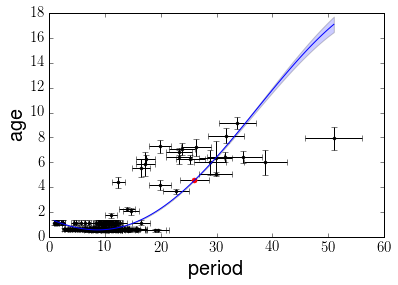

In [7]:
plot_2d_prediction(period, age, period_err, age_err, mu, v, xs[0, 1], [A, lp], "period", "age")

Plot prediction for age vs color.

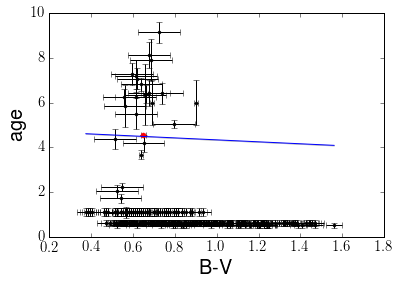

In [8]:
plot_2d_prediction(bv, age, bv_err, age_err, mu, v, xs[0, 0], [A, lbv], "B-V", "age")

Now perform MCMC.

Define initial parameters, prior, likelihood function and log prob.

In [9]:
theta_init = np.log(np.array([A, lbv, lp]))  # initial guess

In [10]:
def lnprior(theta):  # very broad uniform log prior
    if -20 < theta[0] < 20 and -20 < theta[1] < 20 and -20 < theta[2] < 20:
        return 0.
    return -np.inf

In [11]:
def lnlike(theta, x, y, z, yerr):
    theta = np.exp(theta)
    D = np.vstack((x, z)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    gp.compute(D, yerr)   
    return gp.lnlikelihood(y, quiet=True)

In [12]:
def lnprob(theta, x, y, z, yerr):
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)

Set up MCMC.

In [16]:
x, y, z, yerr = bv, age, period, age_err
burnin, nwalkers, ndim = 100, 12, len(theta_init)
runs = np.zeros(5) + 1000
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, z, yerr)

Time the lhf call.

In [17]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, z, yerr))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * sum(runs)/60, "mins")
print("total = ", (tm * nwalkers * sum(runs) + tm * nwalkers * burnin)/60, "mins")

lnprob =  -894.191751819
1 lhf call takes  0.005318880081176758 seconds
burn in will take 6.382656097412109 s
each run will take 5.31888008118 mins
total =  5.4252576828 mins


Run the MCMC.

In [18]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in...")
p0, _, state = sampler.run_mcmc(p0, burnin)
fig_labels = ["A", "lbv", "lp"]

sample_array = np.zeros((nwalkers, sum(runs), ndim))
for i, run in enumerate(runs):
    sampler.reset()
    print("production run, {0} steps".format(int(run)))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    sample_array[:, sum(runs[:i]):sum(runs[:(i+1)]), :] = np.array(sampler.chain)
    f = h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "w")
    data = f.create_dataset("samples", np.shape(sample_array))
    data[:, :] = sample_array
    f.close()
    
    # make plots at increments
    mcmc_result = make_plot(sample_array[:, :sum(runs[:(i+1)]), :], x, y, yerr, fig_labels, "3D", RESULTS_DIR, "3D", traces=True, tri=True, prediction=True)

burning in...
emcee: Exception while calling your likelihood function:
  params: [ 13.78416362   3.09554951   4.4979631 ]
  args: (array([ 0.535     ,  0.543     ,  0.566     ,  0.597     ,  0.601     ,
        0.603     ,  0.609     ,  0.632     ,  0.634     ,  0.741     ,
        0.743     ,  0.746     ,  0.816     ,  0.831     ,  0.883     ,
        0.907     ,  0.987     ,  1.031     ,  1.058     ,  1.067     ,
        1.237     ,  1.357     ,  0.5967    ,  0.4697    ,  0.5197    ,
        0.5117    ,  0.5397    ,  0.6187    ,  0.5587    ,  0.4887    ,
        0.5167    ,  0.5557    ,  0.5507    ,  0.5917    ,  0.5437    ,
        0.5787    ,  0.5977    ,  0.6037    ,  0.5477    ,  0.5887    ,
        0.5467    ,  0.5947    ,  0.6167    ,  0.6697    ,  0.6457    ,
        0.5677    ,  0.6417    ,  0.5737    ,  0.7407    ,  0.5507    ,
        0.5597    ,  0.7077    ,  0.6347    ,  0.6587    ,  0.6987    ,
        0.7527    ,  0.6817    ,  0.6947    ,  0.6887    ,  0.7677    ,
     

Traceback (most recent call last):
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-12-2dc9ab00f005>", line 2, in lnprob
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)
  File "<ipython-input-11-2bc4c713cef2>", line 6, in lnlike
    gp.compute(D, yerr)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/gp.py", line 185, in compute
    self.solver.compute(self._x, self._yerr, **kwargs)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/basic.py", line 69, in compute
    self._factor = (cholesky(K, overwrite_a=True, lower=False), False)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/scipy/linalg/decomp_cholesky.py", line 81, in cholesky
    check_finite=check_finite)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/scipy/linalg/decomp_cholesky.py", line 30, in _cholesky
    raise LinAlgError(

LinAlgError: 263-th leading minor not positive definite

Calculate the age of the Sun.

In [86]:
def age_model(mybv, myperiod, plot=False):
    """
    Given a rotation period and a colour, calculate the age.
    """
    
    # load the data for conditioning...
    age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()
    
    # load the results
    with h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "r") as f:
            samples = f["samples"][...]
    nwalkers, nsteps, ndims = np.shape(samples)
    flat = np.reshape(samples, (nwalkers * nsteps, ndims))
    mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(flat, [16, 50, 84], axis=0)))
    theta = np.exp(np.array([i[0] for i in mcmc_result]))
    
    D = np.vstack((bv, period)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    gp.compute(D, age_err)
    xs = np.zeros((1, 2))
    xs[0, 0] = mybv
    xs[0, 1] = myperiod
    mu, cov = gp.predict(age, xs)  # do the prediction
    v = np.diag(cov)**.5
    
    if plot:
        
        m = (myperiod - 10 < period) * (period < myperiod + 10)
        plt.errorbar(bv[m], age[m], xerr=bv_err[m], yerr=age_err[m], fmt="k.")
        plt.errorbar(mybv, mu, yerr=v, fmt="r.")
        plt.xlabel("B-V")
        plt.ylabel("age")        
        xplot = np.linspace(min(bv[m]), max(bv[m]), 100)
        k = theta[0]**2 * ExpSquaredKernel(theta[1]**2)
        gp = george.GP(k)
        gp.compute(bv[m], age_err[m])
        mus, covs = gp.predict(age[m], xplot)  # do the prediction
        vs = np.diag(covs)**.5
        plt.plot(xplot, mus, label=("period = {0}".format(myperiod)))
        plt.fill_between(xplot, mus-vs, mus+vs, alpha=.2)
        plt.legend()
        plt.show()

        m = (mybv - .1 < bv) * (bv < mybv + .1)
        plt.errorbar(period[m], age[m], xerr=period_err[m], yerr=age_err[m], fmt="k.")
        plt.errorbar(myperiod, mu, yerr=v, fmt="r.")
        plt.xlabel("period")
        plt.ylabel("age")
        xplot = np.linspace(min(period[m]), max(period[m]), 100)
        k = theta[0]**2 * ExpSquaredKernel(theta[2]**2)
        gp = george.GP(k)
        gp.compute(period[m], age_err[m])
        mus, covs = gp.predict(age[m], xplot)  # do the prediction
        vs = np.diag(covs)**.5
        plt.plot(xplot, mus, label=("B-V = {0}".format(mybv)))
        plt.fill_between(xplot, mus-vs, mus+vs, alpha=.2)
        plt.legend()
        plt.show()
    
    print("Age = {0} +/- {1} Gyr".format(mu[0], v[0]))
    return mu, v

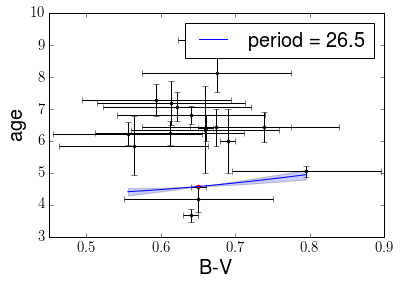

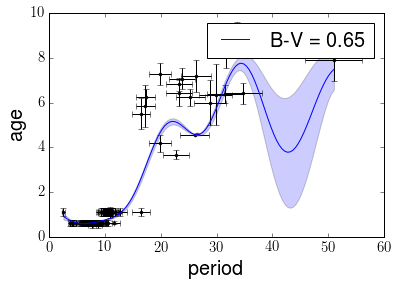

[ 4.0764333   0.86208676  6.86950926]
Age = 4.595719985283309 +/- 0.02539966002312179 Gyr


In [87]:
age = age_model(.65, 26.5, plot=True)